# Linear classifier on bottleneck features from pretrained model.

In [33]:
import os
import shutil
import pandas as pd
import numpy as np
from PIL import Image

In [34]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from matplotlib import pyplot
import seaborn as sns

In [3]:
# Specifying train, validation and test set
path = "/home/ubuntu/nbs/data/seedlings"
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")
preview_path = os.path.join(path, "preview")
checkpoint_path = os.path.join(path, "best_weights.hdf5")

### Data generator

In [13]:
# Get batches from the dirname directory, perform augmentation (rotation, shift, flip, zoom) 
# and return batch genarator object.
def get_batches(dirname, shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
    flow = gen.flow_from_directory(
                        dirname, 
                        shuffle=False,
                        batch_size=batch_size, 
                        class_mode='categorical',
                        target_size=target_size,
                        )

    return flow 


In [16]:
batch_size = 64
train_batches_gen = get_batches(train_path, batch_size=batch_size)
valid_batches_gen = get_batches(valid_path, batch_size=batch_size)
for cl in train_batches_gen.class_indices.keys():
    print(cl)

Found 3070 images belonging to 12 classes.
Found 840 images belonging to 12 classes.
Cleavers
Maize
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Common wheat
Black-grass
Sugar beet
Charlock
Scentless Mayweed
Shepherds Purse
Fat Hen


###  Extracting features from the last activation maps before the fully-connected layer of pre-trained InceptionV3.

In [20]:
# Using InceptionV3 model as feature extractor.
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

train_features = model.predict_generator(train_batches_gen)#, steps=5000/batch_size)
valid_features = model.predict_generator(valid_batches_gen)#, steps=1200/batch_size)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'w'), train_features)

In [21]:
print('Inception train bottleneck features shape: {} size: {:,}'.format(train_features.shape, train_features.size))
print('Inception valid bottleneck features shape: {} size: {:,}'.format(valid_features.shape, valid_features.size))


Inception train bottleneck features shape: (3070, 2048) size: 6,287,360
Inception valid bottleneck features shape: (840, 2048) size: 1,720,320


### Logistic regression on bottleneck features.

In [22]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(train_features, train_batches_gen.classes)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
valid_preds = logreg.predict(valid_features)

In [36]:
print('Validation Accuracy {}'.format(accuracy_score(valid_batches_gen.classes, valid_preds)))


Validation Accuracy 0.758333333333


### Confusion matrix


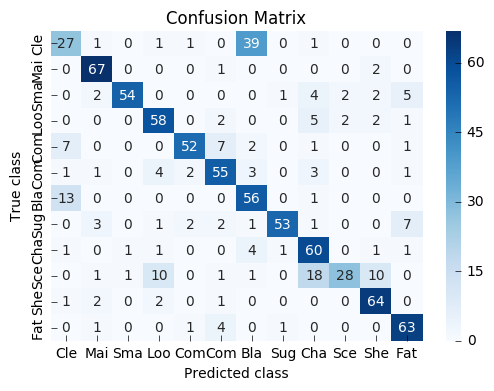

In [31]:
cnf_matrix = confusion_matrix(valid_batches_gen.classes, valid_preds)
fig, ax = pyplot.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=pyplot.cm.Blues, annot=True)
categories = [cat[:3] for cat in train_batches_gen.class_indices.keys()]
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
pyplot.title('Confusion Matrix')
pyplot.ylabel('True class')
pyplot.xlabel('Predicted class')
pyplot.show();